# Simple Neural Network

1. Basic pipeline
1. Sequential NN for binary classification
    1. First layer - 32 nodes, input_dim=400 - use raw data
    1. Second layer - 16 nodes
    1. Output layer - 1 node
1. Gradient Descent optimizaion : adam
1. Binary Cross Entropy loss function : binary classification
1. Accuracy metric

## Imports and Globals

In [65]:
from collections import namedtuple
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import font_utils.load_font as LF

TRIMMED_PATH='/data/udel-ms-data-science/math-637/project-1/char-fonts/trimmed'
ALL_FONTS_CSV=f'{TRIMMED_PATH}/all_fonts.csv'

DATA_COLS=[f'r{row}c{col}' for row in range(20) for col in range(20)]
TARGET_COL=['font_class']
META_COLS=['m_label', 'font', 'variant']

## Read All Font Data

In [73]:
all_df = pd.read_csv(ALL_FONTS_CSV).drop('Unnamed: 0', axis=1)
all_df.dtypes

m_label        int64
r0c0           int64
r0c1           int64
r0c2           int64
r0c3           int64
               ...  
r19c18         int64
r19c19         int64
font          object
variant       object
font_class    object
Length: 404, dtype: object

### Create DataFrames for raw data

1. Randomly shuffle the data first to mix the classes within the data set
1. m_label - the character encoded as ASCII
1. font
1. font variant
1. class_label (TARGET)
    1. 1 - The font character is the given font class
    1. 0 - The font character is not the given font class
1. r0c0...r19c19 (400 elements in raw image data)

In [98]:
class_counts = {
    cc_i:cc_v for cc_i, cc_v in all_df.groupby(by='font_class').count().m_label.items()
}

BY_CLASS = {c:all_df.loc[all_df.font_class == c] for c in ['mo', 'os', 'ss', 'tr']}

WITHOUT = {
    'mo' : ['os', 'ss', 'tr'],
    'os' : ['mo', 'ss', 'tr'],
    'ss' : ['mo', 'os', 'tr'],
    'tr' : ['mo', 'os', 'ss']    
}

RAW_INPUT_DICT = dict()
for k,v in class_counts.items():
    one_third = int(v/3)
#     print(f'{k} : {v} : {one_third} : {WITHOUT[k]}')
    others = list()
    for c in WITHOUT[k]:
        others.append(BY_CLASS[c].sample(frac=float(one_third/class_counts[c])).reset_index(drop=True))
    others.append(BY_CLASS[k])
#     print(f'Len of others {len(others)}')
    t_df = pd.DataFrame().append(others).sample(frac=1).reset_index(drop=True)
    t_df['font_class'] = np.where(t_df.font_class == k, 1, 0)
    t_df['font_class'] = t_df['font_class'].astype(int)
    RAW_INPUT_DICT[k] = t_df
    
for c, df in RAW_INPUT_DICT.items():
    print(f'{c} {df.shape}')

mo (3470, 404)
os (2726, 404)
ss (5702, 404)
tr (2479, 404)


## Split Data Into Train/Test

1. X cols: r0c0,...,r19c19
1. Y cols: font_class
1. Others: m_label, font, variant

In [99]:
df = RAW_INPUT_DICT['ss']
X = df.loc[:, DATA_COLS]
Y = df.loc[:, TARGET_COL]
M = df.loc[:, META_COLS]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

## Setup Sequential Neural Network

In [106]:
L1_NODES = 16
L2_NODES = 8
INPUT_DIMS = 400

nn = Sequential()
nn.add(Dense(L1_NODES, activation='relu',input_dim=INPUT_DIMS))
nn.add(Dense(L2_NODES, activation='relu'))
nn.add(Dense(1,activation='sigmoid'))

nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

print(f'Start {datetime.now()}')
nn.fit(X_train,Y_train, epochs=200,verbose=0)
print(f'Stop  {datetime.now()}')

scores = nn.evaluate(X_train,Y_train)
print(f'Training Accurancy {scores[1]*100}')

scores = nn.evaluate(X_test,Y_test)
print(f'Test Accurancy {scores[1]*100}')

Start 2021-05-22 21:15:56.650739
Stop  2021-05-22 21:16:05.585438
114/114 [==============================] - 0s 464us/step - loss: 0.0642 - accuracy: 0.9866
Training Accurancy 98.65679740905762
36/36 [==============================] - 0s 658us/step - loss: 0.4384 - accuracy: 0.9176
Test Accurancy 91.76161289215088


## Confusion Matrix

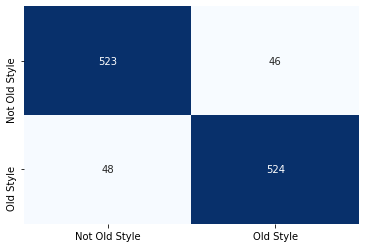

In [107]:
y_test_pred = nn.predict_classes(X_test)
c_matrix = confusion_matrix(Y_test, y_test_pred)
ax = sns.heatmap(
    c_matrix, 
    annot=True,
    xticklabels=['Not Old Style', 'Old Style'],
    yticklabels=['Not Old Style', 'Old Style'],
    cbar=False,
    cmap='Blues',
    fmt='g'
)
ax.set_xlabel='Prediction'
ax.set_ylabel='Actual'

## ROC Curve

Text(0, 0.5, 'True Positive Rate')

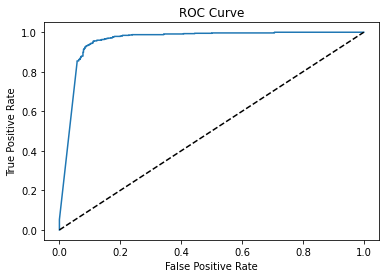

In [108]:
y_test_pred_probs = nn.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_test_pred_probs)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', color='black')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')